# Statistical downscaling model

Abstract: This ipython notebook is showing the entile process of both extracting data and building model.

Author: Li Yafei, at Beijing Normal University

## Input dataset:
* GHCN-M, as observational data to train the model, and to validate the model.
* NCEP, used to extract a suite of predictors.

## Output result set:
* temperature series (date, station name)
* station info (station name, elevation, longitude, latitude)

* potential predictors (PC_VALUE	YEAR	EV	I_PC	MONTH	VAR_NAME	LEVEL	STATION_NAME)

* metrics_result (CC_test	CC_train	MAE_test	MAE_train	MONTH	R2_test	R2_train	RMSE_test	RMSE_train	STATION_NAME)
* predicted_values (MONTH	PREDICTED	STATION_NAME	TRAIN_TEST	YEAR)
* coefficients (MONTH	STATION_NAME	W_0	W_1	W_2	W_3	W_4)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_rows',6)

In [4]:
kz_ghcn_raw = pd.read_csv('KZ_1980_2000_GHCN.csv')

In [5]:
kz_ghcn_raw

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,EMXP,Missing,Consecutive Missing,MXSD,...,Consecutive Missing.4,MMXT,Missing.5,Consecutive Missing.5,MMNT,Missing.6,Consecutive Missing.6,MNTM,Missing.7,Consecutive Missing.7
0,GHCND:KZ000036639,URDZHAR KZ,491,47.117,81.617,19530301,-9999,0,0,-9999,...,5,39,5,5,0,5,5,20,5,5
1,GHCND:KZ000036639,URDZHAR KZ,491,47.117,81.617,19530501,-9999,0,0,-9999,...,30,339,29,29,139,30,30,-9999,0,0
2,GHCND:KZ000036639,URDZHAR KZ,491,47.117,81.617,19530601,20,0,0,-9999,...,5,277,26,17,128,9,5,200,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42398,GHCND:KZ000028978,BALKASINO KZ,399,52.533,68.750,20150701,-9999,0,0,-9999,...,4,245,1,1,99,12,4,180,12,4
42399,GHCND:KZ000028978,BALKASINO KZ,399,52.533,68.750,20150801,-9999,0,0,-9999,...,2,220,0,0,64,10,2,138,10,2
42400,GHCND:KZ000028978,BALKASINO KZ,399,52.533,68.750,20150901,-9999,0,0,-9999,...,2,171,0,0,22,8,2,103,8,2


In [6]:
kz_ghcn_raw['DATE'] = pd.to_datetime(kz_ghcn_raw['DATE'].astype(str))

In [7]:
kz_ghcn_raw

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,EMXP,Missing,Consecutive Missing,MXSD,...,Consecutive Missing.4,MMXT,Missing.5,Consecutive Missing.5,MMNT,Missing.6,Consecutive Missing.6,MNTM,Missing.7,Consecutive Missing.7
0,GHCND:KZ000036639,URDZHAR KZ,491,47.117,81.617,1953-03-01,-9999,0,0,-9999,...,5,39,5,5,0,5,5,20,5,5
1,GHCND:KZ000036639,URDZHAR KZ,491,47.117,81.617,1953-05-01,-9999,0,0,-9999,...,30,339,29,29,139,30,30,-9999,0,0
2,GHCND:KZ000036639,URDZHAR KZ,491,47.117,81.617,1953-06-01,20,0,0,-9999,...,5,277,26,17,128,9,5,200,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42398,GHCND:KZ000028978,BALKASINO KZ,399,52.533,68.750,2015-07-01,-9999,0,0,-9999,...,4,245,1,1,99,12,4,180,12,4
42399,GHCND:KZ000028978,BALKASINO KZ,399,52.533,68.750,2015-08-01,-9999,0,0,-9999,...,2,220,0,0,64,10,2,138,10,2
42400,GHCND:KZ000028978,BALKASINO KZ,399,52.533,68.750,2015-09-01,-9999,0,0,-9999,...,2,171,0,0,22,8,2,103,8,2


In [8]:
def separate_country_name(GHCN):
    GHCN['COUNTRY_NAME'] = GHCN['STATION_NAME'].apply(lambda x: x[-2:])
    GHCN['STATION_NAME'] = GHCN['STATION_NAME'].apply(lambda x: x[:-3])

In [9]:
separate_country_name(kz_ghcn_raw)

In [10]:
kz_ghcn_raw

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,EMXP,Missing,Consecutive Missing,MXSD,...,MMXT,Missing.5,Consecutive Missing.5,MMNT,Missing.6,Consecutive Missing.6,MNTM,Missing.7,Consecutive Missing.7,COUNTRY_NAME
0,GHCND:KZ000036639,URDZHAR,491,47.117,81.617,1953-03-01,-9999,0,0,-9999,...,39,5,5,0,5,5,20,5,5,KZ
1,GHCND:KZ000036639,URDZHAR,491,47.117,81.617,1953-05-01,-9999,0,0,-9999,...,339,29,29,139,30,30,-9999,0,0,KZ
2,GHCND:KZ000036639,URDZHAR,491,47.117,81.617,1953-06-01,20,0,0,-9999,...,277,26,17,128,9,5,200,10,6,KZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42398,GHCND:KZ000028978,BALKASINO,399,52.533,68.750,2015-07-01,-9999,0,0,-9999,...,245,1,1,99,12,4,180,12,4,KZ
42399,GHCND:KZ000028978,BALKASINO,399,52.533,68.750,2015-08-01,-9999,0,0,-9999,...,220,0,0,64,10,2,138,10,2,KZ
42400,GHCND:KZ000028978,BALKASINO,399,52.533,68.750,2015-09-01,-9999,0,0,-9999,...,171,0,0,22,8,2,103,8,2,KZ


In [11]:
start_year = 1960
end_year = 2009
interested_cols_list = ['STATION_NAME',
                        'MNTM','Missing.7',
                        'Consecutive Missing.7', 
                        'ELEVATION','LATITUDE',
                        'LONGITUDE']

In [12]:
def select_from_GHCN(GHCN, start, end, cols):
    return GHCN.set_index('DATE').ix[str(start_year):str(end_year),interested_cols_list]

In [13]:
kz_selected = select_from_GHCN(kz_ghcn_raw, start_year, end_year, interested_cols_list)

In [14]:
kz_selected

,STATION_NAME,MNTM,Missing.7,Consecutive Missing.7,ELEVATION,LATITUDE,LONGITUDE
DATE,,,,,,,
1960-01-01,URDZHAR,-9999,0,0,491,47.117,81.617
1960-02-01,URDZHAR,-9999,0,0,491,47.117,81.617
1960-03-01,URDZHAR,-9999,0,0,491,47.117,81.617
...,...,...,...,...,...,...,...
2009-10-01,BALKASINO,44,12,2,399,52.533,68.750
2009-11-01,BALKASINO,-61,12,4,399,52.533,68.750
2009-12-01,BALKASINO,-180,15,3,399,52.533,68.750


In [15]:
def drop_nan_rows(GHCN, nan_value=-9999):
    GHCN.loc[GHCN['MNTM']==nan_value, 'MNTM'] = np.nan
    # GHCN.loc[GHCN['Missing.7']>15,'MNTM'] = np.nan
    GHCN.dropna(inplace=True)


In [16]:
drop_nan_rows(kz_selected)

In [17]:
kz_selected

,STATION_NAME,MNTM,Missing.7,Consecutive Missing.7,ELEVATION,LATITUDE,LONGITUDE
DATE,,,,,,,
1960-08-01,URDZHAR,195,22,22,491,47.117,81.617
1961-09-01,URDZHAR,170,10,10,491,47.117,81.617
1962-05-01,URDZHAR,203,23,23,491,47.117,81.617
...,...,...,...,...,...,...,...
2009-10-01,BALKASINO,44,12,2,399,52.533,68.750
2009-11-01,BALKASINO,-61,12,4,399,52.533,68.750
2009-12-01,BALKASINO,-180,15,3,399,52.533,68.750


In [18]:
ideal_value = (end_year - start_year + 1) * 12
actual_values = kz_selected.groupby('STATION_NAME').size()
candidates = list(actual_values[actual_values==ideal_value].index)

In [19]:
candidates

['AKTOBE',
 'ARALSKOE MORE',
 'ATBASAR',
 'ATYRAU',
 'BALHASH',
 'IRTYSHSK',
 'PETROPAVLOVSK',
 'SEMEJ',
 'UIL',
 'URALSK',
 'ZHARKENT']

### TEMPERATURE SERIES TABLE

In [20]:
kz_temp_series = kz_selected.ix[kz_selected['STATION_NAME'].isin(candidates),['STATION_NAME','MNTM']]

In [21]:
kz_temp_series

,STATION_NAME,MNTM
DATE,,
1960-01-01,AKTOBE,-115
1960-02-01,AKTOBE,-127
1960-03-01,AKTOBE,-139
...,...,...
2009-10-01,UIL,101
2009-11-01,UIL,9
2009-12-01,UIL,-90


In [22]:
kz_temp_series.reset_index().set_index(['DATE','STATION_NAME']).MNTM.unstack('STATION_NAME')/10

STATION_NAME,AKTOBE,ARALSKOE MORE,ATBASAR,ATYRAU,BALHASH,IRTYSHSK,PETROPAVLOVSK,SEMEJ,UIL,URALSK,ZHARKENT
DATE,,,,,,,,,,,
1960-01-01,-11.5,-9.1,-15.3,-4.6,-13.2,-19.7,-18.2,-15.9,-8.6,-8.7,-7.4
1960-02-01,-12.7,-8.6,-15.4,-6.2,-11.7,-13.9,-15.1,-14.0,-11.0,-12.3,-2.6
1960-03-01,-13.9,-10.5,-17.1,-4.9,-11.7,-16.1,-16.1,-13.6,-11.6,-10.8,0.9
...,...,...,...,...,...,...,...,...,...,...,...
2009-10-01,3.5,11.3,5.4,12.4,8.5,3.2,9.5,6.6,10.1,8.6,12.3
2009-11-01,-1.2,1.0,-4.5,2.0,-2.6,-6.1,-4.7,-4.5,0.9,-1.3,2.9
2009-12-01,-10.4,-9.5,-19.2,-4.1,-12.6,-19.3,-18.4,-16.1,-9.0,-6.4,-4.4


In [23]:
def switch_dimension(df, index_name, col_name, value_column):
    df = df.reset_index()
    df = df.set_index([index_name,col_name])[value_column]
    df = df.unstack(col_name)
    return df

In [24]:
kz_temp_series = switch_dimension(kz_temp_series, 'DATE', 'STATION_NAME', 'MNTM')/10

In [25]:
kz_temp_series

STATION_NAME,AKTOBE,ARALSKOE MORE,ATBASAR,ATYRAU,BALHASH,IRTYSHSK,PETROPAVLOVSK,SEMEJ,UIL,URALSK,ZHARKENT
DATE,,,,,,,,,,,
1960-01-01,-11.5,-9.1,-15.3,-4.6,-13.2,-19.7,-18.2,-15.9,-8.6,-8.7,-7.4
1960-02-01,-12.7,-8.6,-15.4,-6.2,-11.7,-13.9,-15.1,-14.0,-11.0,-12.3,-2.6
1960-03-01,-13.9,-10.5,-17.1,-4.9,-11.7,-16.1,-16.1,-13.6,-11.6,-10.8,0.9
...,...,...,...,...,...,...,...,...,...,...,...
2009-10-01,3.5,11.3,5.4,12.4,8.5,3.2,9.5,6.6,10.1,8.6,12.3
2009-11-01,-1.2,1.0,-4.5,2.0,-2.6,-6.1,-4.7,-4.5,0.9,-1.3,2.9
2009-12-01,-10.4,-9.5,-19.2,-4.1,-12.6,-19.3,-18.4,-16.1,-9.0,-6.4,-4.4


In [26]:
def get_monthly_series(df, start_year_month, station_name, end_year_month=None):
    
    series_of_month = df.ix[start_year_month:end_year_month:12, station_name]
    
    return series_of_month


In [27]:
kz_temp_series

STATION_NAME,AKTOBE,ARALSKOE MORE,ATBASAR,ATYRAU,BALHASH,IRTYSHSK,PETROPAVLOVSK,SEMEJ,UIL,URALSK,ZHARKENT
DATE,,,,,,,,,,,
1960-01-01,-11.5,-9.1,-15.3,-4.6,-13.2,-19.7,-18.2,-15.9,-8.6,-8.7,-7.4
1960-02-01,-12.7,-8.6,-15.4,-6.2,-11.7,-13.9,-15.1,-14.0,-11.0,-12.3,-2.6
1960-03-01,-13.9,-10.5,-17.1,-4.9,-11.7,-16.1,-16.1,-13.6,-11.6,-10.8,0.9
...,...,...,...,...,...,...,...,...,...,...,...
2009-10-01,3.5,11.3,5.4,12.4,8.5,3.2,9.5,6.6,10.1,8.6,12.3
2009-11-01,-1.2,1.0,-4.5,2.0,-2.6,-6.1,-4.7,-4.5,0.9,-1.3,2.9
2009-12-01,-10.4,-9.5,-19.2,-4.1,-12.6,-19.3,-18.4,-16.1,-9.0,-6.4,-4.4


In [28]:
get_monthly_series(kz_temp_series,'1960-02','AKTOBE')

DATE
1960-02-01   -12.7
1961-02-01   -12.2
1962-02-01   -10.5
              ... 
2007-02-01   -11.2
2008-02-01    -7.2
2009-02-01   -10.3
Name: AKTOBE, dtype: float64

In [29]:
july_test_series = get_monthly_series(kz_temp_series,'1960-06','ATBASAR')

In [30]:
from sklearn import preprocessing

In [31]:
kz_temp_series_scaled = preprocessing.scale(kz_temp_series)

In [32]:
mu = july_test_series.mean(axis=0)
sigma = july_test_series.std(axis=0)
scaled = (july_test_series - mu)/sigma

### STATION INFORMATION TABLE

In [33]:
kz_station_info = kz_selected.reset_index()
kz_station_info = kz_station_info.ix[kz_station_info['STATION_NAME'].isin(candidates),
                   ['STATION_NAME','ELEVATION','LATITUDE','LONGITUDE']]
kz_station_info = kz_station_info.drop_duplicates()

In [34]:
kz_station_info

,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE
885,AKTOBE,219,50.2831,57.1500
1485,ARALSKOE MORE,62,46.7794,61.6694
2085,URALSK,36,51.2500,51.4000
...,...,...,...,...
13123,PETROPAVLOVSK,142,54.8331,69.1500
16067,ZHARKENT,645,44.1667,80.0667
20900,UIL,128,49.0667,54.6831


In [35]:
def plot_locations(data_frame):
    lat_KZ = np.array(data_frame['LATITUDE'])
    lon_KZ = np.array(data_frame['LONGITUDE'])


    %matplotlib inline
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    import cartopy.feature as cfeature
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()
    ax.set_extent([42,88,30,60])

    countries = cfeature.NaturalEarthFeature(\
                                            category='cultural',\
                                            name='admin_0_countries',\
                                            scale='50m',\
                                            facecolor='none')
    ax.add_feature(countries)
    dots2 = plt.scatter(lon_KZ,lat_KZ, color='red',transform=ccrs.Geodetic(),label='Stations')

    ax.legend()

/home/ek777/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ek777/anaconda/lib/python2.7/site-packages/numpy/lib/shape_base.py:431: FutureWarning: in the future np.array_split will retain the shape of arrays with a zero size, instead of replacing them by `array([])`, which always has a shape of (0,).
  FutureWarning)


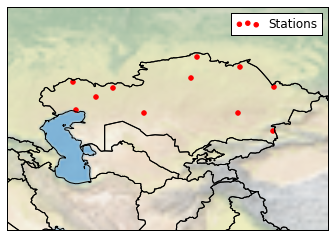

In [36]:
plot_locations(kz_station_info)

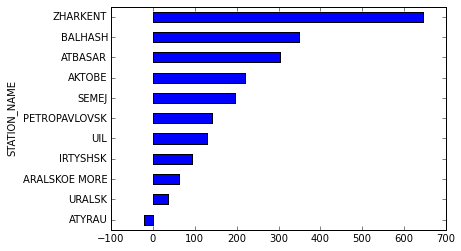

In [37]:
kz_station_info.set_index('STATION_NAME').ELEVATION.sort_values().plot(kind='barh')

## SAVE OUTPUT TO PICKLE

In [38]:
kz_temp_series.to_pickle('kz_temp_series.pkl')

In [39]:
kz_station_info.to_pickle('kz_station_info.pkl')

## NCEP, Extract predictors

In [40]:
%matplotlib inline
import os
import xray
import numpy as np


def point_to_center_dict(pLat, pLon, iLat=2.5, iLon=2.5):
    
    # iLat and iLon are the intervals between nodes
    
    cLat = int((pLat + iLat / 2) / iLat) * iLat  # c means CENTRER
    cLon = int((pLon + iLon / 2) / iLon) * iLon

    return {'cLat':cLat, 'cLon':cLon}



def get_interested_month_slice(interested_month, start_year, end_year):

    start = str(start_year) + '-' + str(interested_month)

    end = str(end_year) + '-' + str(interested_month)
    
    return slice(start,end,12)



def extract_subset_dict_for_month_and_point(i_month=7,
                                            i_year_start=1960,
                                            i_year_end=2009,
                                            i_level=850,
                                            i_point_lat=51.8167,
                                            i_point_lon=68.3667,
                                            i_nodes_expanded=1, 
                                            i_Lat=2.5, 
                                            i_Lon=2.5):
    
    # construct a dict containing all selection info
    
    domain_dict = point_to_center_dict( i_point_lat , i_point_lon , i_Lat, i_Lon)
    
    cLat = domain_dict['cLat']
    cLon = domain_dict['cLon']
    
    lat=slice(cLat + i_nodes_expanded * i_Lat, cLat - i_nodes_expanded * i_Lat)
    lon=slice(cLon - i_nodes_expanded * i_Lon, cLon + i_nodes_expanded * i_Lon)
        
    parameter_dict = {'lat':lat, 'lon':lon}
    
    
    time_dict = dict(time=get_interested_month_slice(i_month,i_year_start, i_year_end))    
    parameter_dict.update(time_dict)
    
    
    level_dict = {'level':i_level}
    parameter_dict.update(level_dict)
    
    return parameter_dict



from sklearn import preprocessing
from sklearn.decomposition import pca
import pandas as pd


def get_PCs_info(dsub, i_year_start, i_year_end, threshold=0.90):
    dim_lat = dsub['lat'].values
    dim_lon = dsub['lon'].values
    var_values = dsub.values

    var_values = np.reshape(var_values, (var_values.shape[0], len(dim_lat) * len(dim_lon)), order='F')
    
    var_values_scaled = preprocessing.scale(var_values)
    
    skpca = pca.PCA()
    skpca.fit(var_values_scaled)
    PCs = skpca.transform(var_values_scaled)

    i = 0
    pc_info_list = []
    while True:

        explained_variance = skpca.explained_variance_ratio_[i]
        pc_value = PCs[:,i]

        row = {'PC_VALUE':pc_value,'YEAR': np.arange(i_year_start,i_year_end+1)}
        df_pc_year = pd.DataFrame(row)
        df_pc_year['EV'] = explained_variance
        df_pc_year['I_PC'] = i+1
        pc_info_list.append(df_pc_year)    
        if skpca.explained_variance_ratio_.cumsum()[i] >= threshold:
            break
        i = i+1
    return pd.concat(pc_info_list)




def get_PC_main(dset, i_point_lat, i_point_lon, i_year_start, i_year_end, i_month, i_var, i_level):
    
    # i for interested
    i_point_lat = i_point_lat
    i_point_lon = i_point_lon

    i_year_start = i_year_start
    i_year_end = i_year_end
    i_month = i_month

    i_var = i_var

    i_level = i_level
    
    
    
    # select a sub area for both time and spatial dimensions
    subset_parameters_dict = extract_subset_dict_for_month_and_point(   i_month = i_month,
                                                                    i_year_start = i_year_start,
                                                                    i_year_end = i_year_end,
                                                                    i_level = i_level,
                                                                    i_point_lat = i_point_lat,
                                                                    i_point_lon = i_point_lon)
    
    dsub = dset[i_var].loc[subset_parameters_dict]
    
    
    # extract the first several PCs 
    
    pc_table = get_PCs_info(dsub,i_year_start, i_year_end, threshold=0.90)
    
    pc_table['MONTH'] = i_month
    pc_table['VAR_NAME'] = i_var
    pc_table['LEVEL'] = i_level
    
    return pc_table


def loop_for_var(dset, station_pd, i_year_start, i_year_end, i_var, i_level_list=[925., 850., 500.]):
    
    result_table = []
    
    for row in range(len(station_pd)):
        i_point_lat = station_pd.iloc[row].ix['LATITUDE']
        i_point_lon = station_pd.iloc[row].ix['LONGITUDE']   
    
        i_var = i_var

        levels = i_level_list
        months = range(1,13)

        table_list_month = []

        for month in months:    
            for level in levels:
                table_list_month.append(get_PC_main(dset, i_point_lat, i_point_lon, i_year_start, i_year_end, month, i_var, level))
        
        table_list_station = pd.concat(table_list_month, ignore_index=True)
        table_list_station['STATION_NAME'] = station_pd.iloc[row].ix['STATION_NAME']
        result_table.append(table_list_station)
    
    #print result_table
    
    return pd.concat(result_table, ignore_index=True)


def final_extract(station_pd, var_list, i_year_start, i_year_end, level_list=[925., 850., 500.]):
    
    nc_path = '/home/ek777/Documents/Downscaling/ncep_monthly_mean/surface'
    
    result_list = []
    
    for var in var_list:
        nc_name = str(var) + '.mon.mean.nc'
        path = os.path.join(nc_path, nc_name)
        dset = xray.open_dataset(path)
        
        result_list.append(loop_for_var(dset, station_pd, i_year_start, i_year_end, var, level_list))
        
        #print('%s has completed.' % str(var))
    
    final_result_PC_info = pd.concat(result_list, ignore_index=True)    
    
    return final_result_PC_info

In [41]:
kz_station_info.sort_values('LONGITUDE')

,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE
2085,URALSK,36,51.2500,51.4000
2685,ATYRAU,-22,47.1167,51.9167
20900,UIL,128,49.0667,54.6831
...,...,...,...,...
12419,IRTYSHSK,94,53.3500,75.4500
16067,ZHARKENT,645,44.1667,80.0667
10678,SEMEJ,196,50.4167,80.3000


In [42]:
year_start = 1960
year_end = 2009

var_list = ['air', 'hgt', 'uwnd', 'vwnd']
level_list = [925., 500., 200.]

In [43]:
potential_predictors = final_extract(kz_station_info, var_list, year_start, year_end,level_list)

In [44]:
potential_predictors

,PC_VALUE,YEAR,EV,I_PC,MONTH,VAR_NAME,LEVEL,STATION_NAME
0,-1.223431,1960,0.956557,1,1,air,925,AKTOBE
1,-2.272114,1961,0.956557,1,1,air,925,AKTOBE
2,-1.069075,1962,0.956557,1,1,air,925,AKTOBE
...,...,...,...,...,...,...,...,...
106547,-0.191719,2007,0.082115,2,12,vwnd,200,UIL
106548,-0.550271,2008,0.082115,2,12,vwnd,200,UIL
106549,0.071014,2009,0.082115,2,12,vwnd,200,UIL


##SAVE TO PICKLE

In [82]:
potential_predictors.to_pickle('potential_predictors.pkl')

## Train model and get a result

### partitioning into train and test period

In [159]:
potential_predictors['P_NAME'] = potential_predictors['VAR_NAME'].apply(str) + potential_predictors['LEVEL'].apply(int).apply(str) 

In [160]:
predictors = potential_predictors.set_index(['I_PC','MONTH','STATION_NAME']).loc[1,['YEAR','PC_VALUE','P_NAME']]

In [161]:
#final_predictor_list = ['air925','hgt200','uwnd925','vwnd925']

In [162]:
final_predictor_list = ['air925','air500','air200','hgt925','hgt500','hgt200','uwnd925','uwnd500','uwnd200','vwnd925','vwnd500','vwnd200']

In [163]:
predictors

YEAR  PC_VALUE   P_NAME
MONTH STATION_NAME                         
1     AKTOBE        1960 -1.223431   air925
      AKTOBE        1961 -2.272114   air925
      AKTOBE        1962 -1.069075   air925
...                  ...       ...      ...
12    UIL           2007 -1.972995  vwnd200
      UIL           2008 -2.571914  vwnd200
      UIL           2009 -3.129881  vwnd200

[79200 rows x 3 columns]

In [164]:
predictors = predictors.reset_index().set_index(['MONTH', 'YEAR','STATION_NAME','P_NAME'])['PC_VALUE'].unstack('P_NAME').loc[:,final_predictor_list]

In [165]:
predictors = predictors.reset_index()

In [166]:
predictors

P_NAME,MONTH,YEAR,STATION_NAME,air925,air500,air200,hgt925,hgt500,hgt200,uwnd925,uwnd500,uwnd200,vwnd925,vwnd500,vwnd200
0,1,1960,AKTOBE,-1.223431,-4.603653,-2.000432,-1.195890,-1.857399,-4.016734,-2.226666,-0.386285,-0.924289,0.112120,-0.040908,-0.120000
1,1,1960,ARALSKOE MORE,-1.538834,-4.577942,-1.296937,-1.909870,-2.067994,-4.092772,-0.202089,-0.685052,-0.897614,-1.418405,-0.479020,-0.999251
2,1,1960,ATBASAR,0.415180,-3.833192,-1.813568,0.008591,-1.458931,-3.253461,-3.230345,-1.066267,-1.642055,0.689194,-1.176444,-1.760399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6597,12,2009,UIL,0.988500,-2.223237,-3.120352,-0.993498,-1.207224,-0.996246,0.725941,-1.679779,-0.537201,3.848360,-3.118259,-3.129881
6598,12,2009,URALSK,1.542288,-1.605622,-2.070755,-1.328005,-0.820205,-0.932760,0.760843,-2.654860,-1.611344,2.006041,-2.333727,-2.694262
6599,12,2009,ZHARKENT,-0.948631,-0.897609,4.496739,1.580088,0.583140,1.012196,1.293570,2.410859,-1.249754,-0.284430,-2.488243,-2.071969


In [189]:
predictors_alpha = predictors[predictors.STATION_NAME=='AKTOBE'].set_index('MONTH').loc[[1,7],:].reset_index()

In [263]:
def train_model(predictors, predictand_df, model):
    
    metrics_result_list = []
    predicted_values_list = []
    coefficients_list = []


    for key, value in  predictors.groupby(['MONTH','STATION_NAME']):

        key = list(key)

    #------------------------------------------------
    #---------------Partitioning ----------------
    #------------------------------------------------    


        train_start_date = str(year_start)+'-'+str(key[0])    
        train_end_date = str(cut_year-1)+'-'+str(key[0])

        test_start_date = str(cut_year)+'-'+str(key[0])
        test_end_date = str(year_end)+'-'+str(key[0])

        station_name = key[1]

        predictand_train = get_monthly_series(predictand_df,train_start_date,station_name,train_end_date)
        predictand_test = get_monthly_series(predictand_df,test_start_date,station_name,test_end_date) 

        predictor_train = value.set_index('YEAR').loc[year_start:cut_year-1, final_predictor_list]
        predictor_test = value.set_index('YEAR').loc[cut_year:year_end, final_predictor_list]

    #------------------------------------------------
    #---------------Train model----------------
    #------------------------------------------------

        model.fit(predictor_train, predictand_train)


    #------------------------------------------------
    #---------------Predicting-------------------
    #------------------------------------------------
        predicted_train = model.predict(predictor_train)
        predicted_test = model.predict(predictor_test)

        MAE_train = mean_absolute_error(predictand_train, predicted_train)
        RMSE_train = mean_squared_error(predictand_train, predicted_train) ** 0.5
        R2_train = r2_score(predictand_train, predicted_train)
        CC_train = R2_train ** 0.5    

        MAE_test = mean_absolute_error(predictand_test, predicted_test)
        RMSE_test = mean_squared_error(predictand_test, predicted_test) ** 0.5
        R2_test = r2_score(predictand_test, predicted_test)
        CC_test = R2_test ** 0.5

        element_metrics = {'MONTH':key[0], 'STATION_NAME':station_name,
                   'MAE_train':MAE_train,'MAE_test':MAE_test, 
                   'RMSE_train':RMSE_train,'RMSE_test':RMSE_test,
                   'R2_train':R2_train,'R2_test':R2_test,'CC_train':CC_train, 'CC_test':CC_test}

        metrics_result_list.append(element_metrics)

        element_values_train = {'MONTH':key[0], 'STATION_NAME':station_name,
                          'YEAR':range(year_start,cut_year),'PREDICTED':predicted_train,'TRAIN_TEST':'train'}
        element_values_test = {'MONTH':key[0], 'STATION_NAME':station_name,
                          'YEAR':range(cut_year,year_end+1),'PREDICTED':predicted_test,'TRAIN_TEST':'test'}
        predicted_values_list.append( pd.concat([pd.DataFrame(element_values_train),pd.DataFrame(element_values_test)],axis=0)  )

        coef_dict = {'MONTH':key[0], 'STATION_NAME':station_name}
        for i,value in enumerate(model.coef_):
            coef_dict.update({'W_'+str(i+1):value})
        coef_dict.update({'W_0':model.intercept_})

        coefficients_list.append(coef_dict)


    metrics_result = pd.DataFrame(metrics_result_list)
    predicted_values = pd.concat(predicted_values_list, axis=0)
    coefficients = pd.DataFrame(coefficients_list)
    
    return coefficients


year_start = 1960
year_end = 2009

# include left, and exclude right
cut_year = 1990

#model = linear_model.LinearRegression()
#model = linear_model.Ridge()

n_alphas = 20
alphas = np.logspace(-3, 5, n_alphas)

coefs_list = []
for a in alphas:
    model = linear_model.Ridge(a)
    coef_alpha = train_model(predictors_alpha, kz_temp_series, model)
    coef_alpha['ALPHA']=a
    coefs_list.append(coef_alpha)

coefs = pd.concat(coefs_list, axis=0)


In [264]:
alphas

array([  1.00000000e-03,   2.63665090e-03,   6.95192796e-03,
         1.83298071e-02,   4.83293024e-02,   1.27427499e-01,
         3.35981829e-01,   8.85866790e-01,   2.33572147e+00,
         6.15848211e+00,   1.62377674e+01,   4.28133240e+01,
         1.12883789e+02,   2.97635144e+02,   7.84759970e+02,
         2.06913808e+03,   5.45559478e+03,   1.43844989e+04,
         3.79269019e+04,   1.00000000e+05])

In [265]:
y = coefs[coefs.MONTH==1].ix[:,3:-1]

In [296]:
import seaborn as sns

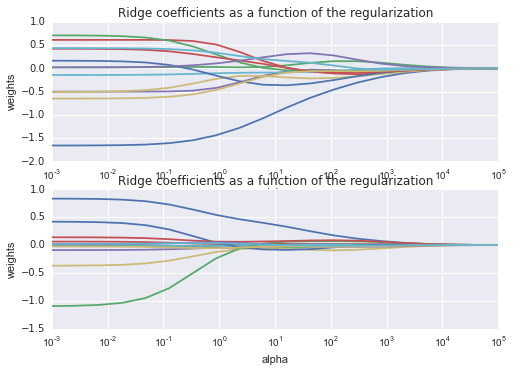

In [297]:
 y = coefs[coefs.MONTH==1].ix[:,3:-1]
ax = plt.subplot(211)
#ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas,y)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')

 y = coefs[coefs.MONTH==7].ix[:,3:-1]
ax = plt.subplot(212)
#ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas,y)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')

In [313]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['Fangsong'] #指定默认字体  
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
# sns.axes_style()，可以看到是否成功设定字体为微软雅黑。

In [314]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
from matplotlib.font_manager import FontManager
import subprocess

fm = FontManager()
mat_fonts = set(f.name for f in fm.ttflist)

output = subprocess.check_output(
    'fc-list :lang=zh -f "%{family}\n"', shell=True)
# print '*' * 10, '系统可用的中文字体', '*' * 10
# print output
zh_fonts = set(f.split(',', 1)[0] for f in output.split('\n'))
available = mat_fonts & zh_fonts

print '*' * 10, '可用的字体', '*' * 10
for f in available:
    print f

In [316]:
coefs.to_pickle('coefs.pkl')

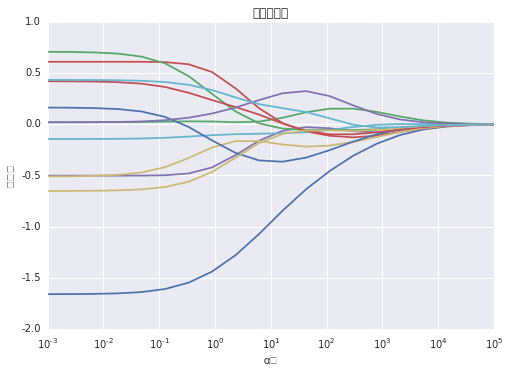

In [315]:
 y = coefs[coefs.MONTH==1].ix[:,3:-1]
ax = plt.gca()
#ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas,y)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('α值')
plt.ylabel('系数值')
plt.title('岭回归系数')

In [ ]:
ax = plt.gca()
#ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [286]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [287]:
year_start = 1960
year_end = 2009

metrics_result_list = []
predicted_values_list = []
coefficients_list = []


# include left, and exclude right
cut_year = 1990

alpha=8




model = linear_model.Ridge(alpha = alpha)


for key, value in  predictors.groupby(['MONTH','STATION_NAME']):
    
    key = list(key)

#------------------------------------------------
#---------------Partitioning ----------------
#------------------------------------------------    
    
    
    train_start_date = str(year_start)+'-'+str(key[0])    
    train_end_date = str(cut_year-1)+'-'+str(key[0])
    
    test_start_date = str(cut_year)+'-'+str(key[0])
    test_end_date = str(year_end)+'-'+str(key[0])
    
    station_name = key[1]
    
    predictand_train = get_monthly_series(kz_temp_series,train_start_date,station_name,train_end_date)
    predictand_test = get_monthly_series(kz_temp_series,test_start_date,station_name,test_end_date) 
    
    predictor_train = value.set_index('YEAR').loc[year_start:cut_year-1, final_predictor_list]
    predictor_test = value.set_index('YEAR').loc[cut_year:year_end, final_predictor_list]
    
#------------------------------------------------
#---------------Train model----------------
#------------------------------------------------

    model.fit(predictor_train, predictand_train)

    
#------------------------------------------------
#---------------Predicting-------------------
#------------------------------------------------
    predicted_train = model.predict(predictor_train)
    predicted_test = model.predict(predictor_test)
    
    MAE_train = mean_absolute_error(predictand_train, predicted_train)
    RMSE_train = mean_squared_error(predictand_train, predicted_train) ** 0.5
    R2_train = r2_score(predictand_train, predicted_train)
    CC_train = R2_train ** 0.5    
    
    MAE_test = mean_absolute_error(predictand_test, predicted_test)
    RMSE_test = mean_squared_error(predictand_test, predicted_test) ** 0.5
    R2_test = r2_score(predictand_test, predicted_test)
    CC_test = R2_test ** 0.5
    
    element_metrics = {'MONTH':key[0], 'STATION_NAME':station_name,
               'MAE_train':MAE_train,'MAE_test':MAE_test, 
               'RMSE_train':RMSE_train,'RMSE_test':RMSE_test,
               'R2_train':R2_train,'R2_test':R2_test,'CC_train':CC_train, 'CC_test':CC_test}
    
    metrics_result_list.append(element_metrics)
    
    element_values_train = {'MONTH':key[0], 'STATION_NAME':station_name,
                      'YEAR':range(year_start,cut_year),'PREDICTED':predicted_train,'TRAIN_TEST':'train'}
    element_values_test = {'MONTH':key[0], 'STATION_NAME':station_name,
                      'YEAR':range(cut_year,year_end+1),'PREDICTED':predicted_test,'TRAIN_TEST':'test'}
    predicted_values_list.append( pd.concat([pd.DataFrame(element_values_train),pd.DataFrame(element_values_test)],axis=0)  )
    
    coef_dict = {'MONTH':key[0], 'STATION_NAME':station_name}
    for i,value in enumerate(model.coef_):
        coef_dict.update({'W_'+str(i+1):value})
    coef_dict.update({'W_0':model.intercept_})
    
    coefficients_list.append(coef_dict)
    
    
metrics_result = pd.DataFrame(metrics_result_list)
predicted_values = pd.concat(predicted_values_list, axis=0)
coefficients = pd.DataFrame(coefficients_list)

In [288]:
coefficients

,MONTH,STATION_NAME,W_0,W_1,W_10,W_11,W_12,W_2,W_3,W_4,W_5,W_6,W_7,W_8,W_9
0,1,AKTOBE,-13.607567,-1.011159,0.033992,0.111907,-0.128262,-0.171167,-0.090397,-0.362039,-0.010181,0.072452,0.257091,-0.153205,0.184558
1,1,ARALSKOE MORE,-11.563979,-0.953944,0.065158,-0.027210,0.033592,-0.123865,0.034390,-0.420509,-0.002461,-0.191293,0.265335,-0.068872,0.035781
2,1,ATBASAR,-16.800848,1.046141,-0.055081,0.236355,-0.133793,-0.266696,-0.055306,0.543887,0.168918,-0.101815,0.046471,0.006706,-0.052376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,12,UIL,-8.169207,-0.817612,-0.038657,-0.012470,0.133903,-0.072317,0.028206,0.333627,0.088322,0.097696,-0.098341,0.361931,-0.055714
130,12,URALSK,-8.586093,-1.076623,-0.007452,0.200473,-0.266178,-0.197776,0.012531,0.304763,0.216625,0.036013,0.132656,-0.123243,0.035814
131,12,ZHARKENT,-4.119279,0.685041,0.152629,-0.293061,-0.033863,0.160415,0.046763,0.402858,-0.408951,0.035657,-0.159821,0.020086,-0.031853


In [289]:
metrics_result

,CC_test,CC_train,MAE_test,MAE_train,MONTH,R2_test,R2_train,RMSE_test,RMSE_train,STATION_NAME
0,0.902171,0.971046,1.547280,0.780395,1,0.813912,0.942931,1.837797,0.953203,AKTOBE
1,0.892039,0.970493,1.782053,0.860909,1,0.795733,0.941856,2.038585,1.021856,ARALSKOE MORE
2,0.902987,0.979611,1.429407,0.709807,1,0.815385,0.959638,1.830579,0.898592,ATBASAR
...,...,...,...,...,...,...,...,...,...,...
129,0.732485,0.927758,1.853146,0.873321,12,0.536534,0.860734,2.315411,1.107811,UIL
130,0.828920,0.933934,1.515219,0.941260,12,0.687108,0.872233,1.967388,1.251525,URALSK
131,NaN,0.980988,1.657775,0.555540,12,-0.239790,0.962338,1.987414,0.712552,ZHARKENT


In [290]:
predicted_values

,MONTH,PREDICTED,STATION_NAME,TRAIN_TEST,YEAR
0,1,-11.910047,AKTOBE,train,1960
1,1,-12.098074,AKTOBE,train,1961
2,1,-12.141441,AKTOBE,train,1962
...,...,...,...,...,...
17,12,-7.846275,ZHARKENT,test,2007
18,12,-3.684214,ZHARKENT,test,2008
19,12,-3.631223,ZHARKENT,test,2009


## SAVE TO PICKLE

In [291]:
predicted_values.to_pickle('predicted_values.pkl')
metrics_result.to_pickle('metrics_result.pkl')
coefficients.to_pickle('coefficients.pkl')